# Description
GAM/NGAM calculation for consensus iCBI model

## Background
In this notebook we train GAM/NGAM parameters using the most comprehensive metabolic flux data set collection we could gather.
The GAM represents ATP used in biomass synthesis, and NGAM corresponds to ATP used for maintenance functions. Biomass composition and maintenance requirement can vary significantly between conditions and genotypes. Thus, the purpose of this value in the model is to establish a baseline for realistic quantitative growth rate predictions, but no to create an accurate description under every possible condition. 

## Approach


__Model configuration__

We start with the iCBI curated model with the final stoichiometry. 
- All secretion products are allowed. While this configuration often leads to the secretion of products which are not commonly observed, it allows to accomodate the most number of experimental points. If more restrective secretion constraints are used, the most descriptive data points (i.e. those in AN7 medium which measure aminoacid, etc) may become unfeasible. While not shown in this notebook, setting the model to only common secretion products, usually does not change the GAM/NGAM values significantly. 
- Experimental fluxes are reported by mean and standard deviation (std), thus they can be constrained in multiple ways, as described in the table below. The "both" approach is preferred since it allows for the most flexibilitiy, and it sets upper bounds, preventing rates highly dissimilar to those measured.
    
|Type| lb | ub|
|----|----|---|
|min| mean-std| 1000|
|mean| mean| 1000|
|max | mean+std| 1000|
|both | mean-std| mean+std|


__Calculation__

1. The NGAM and GAM values are set to 0.
2. The bounds are constrainted to the experimental fluxes, including growth rate, substrate uptake rate, and product secretion rates.
3. The ATP hydrolysis (ATPM) reaction is maximized.
4. The maximum flux of ATPM is plotted against the mean measured growth rate. Linear regression is performed to determine GAM and NGAM which correspond to the slope and intercept of this line, respectively.

## Outcome

- A linear correlation is observed for three different conditions: cellobiose chemostat, cellulose chemostat, and batch reactor (both cellulose and cellobiose). These are saved accordingly in a ATP configuration file.
- A new model, iCBI665_v4 is saved wih the batch GAM/NGAM configuration and cellobiose as a substrate.

# Setup

In [1]:
%matplotlib inline
import os, sys
sys.path.append(os.path.dirname(os.path.abspath('.')))


import matplotlib.pyplot as plt
#plt.style.use('seaborn')
#plt.style.use('ggplot')

#import matplotlib as mpl
#mpl.style.use('ggplot')

import csv
from tools.train_ATP_costs import *
import tools.conf_model
import cobra as cb
import string
import pandas as pd
from scipy import stats
import tools.ms2bigg

In [2]:
def load_model():
    return cb.io.load_json_model(os.path.join(settings.PROJECT_ROOT,'iCBI','intermediate','iCBI665_v6.json'))

model = load_model()

# GAM calculation

Create a table with the different options for maximum ATP estimation.

In [3]:
t_min = train(model, constraint_mode='min')
t_mean = train(model, constraint_mode='mean')
t_max = train(model, constraint_mode='max')
t_both = train(model, constraint_mode='both')

/home/sg/wrk/s/cthermgem-dev/tools/train_ATP_costs.py:41 FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/sg/wrk/s/cthermgem-dev/tools/train_ATP_costs.py:42 FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


Model infeasible for dataset: 0
Model infeasible for dataset: 7
Model infeasible for dataset: 0
Model infeasible for dataset: 1
Model infeasible for dataset: 3
Model infeasible for dataset: 5
Model infeasible for dataset: 6
Model infeasible for dataset: 7
Model infeasible for dataset: 23
Model infeasible for dataset: 24
Model infeasible for dataset: 25
Model infeasible for dataset: 26


In [4]:
ds = pd.read_csv(settings.EXTRACELLULAR_FLUX_DATA)
ds = ds.set_index('index')
ds = ds[['Strain', 'Medium', 'Reactor', 'GR']]

dfs = {'ATP_min': t_min['gamdf'], 'ATP_mean': t_mean['gamdf'], 'ATP_max': t_max['gamdf'], 'ATP_both': t_both['gamdf']}
for col_id, tdf in dfs.items():
    tdf = tdf.set_index('training_dataset_index')
    tdf.index = tdf.index.map(int) # ds as integer indices whie
    atp = tdf.loc[:,['ATP']]
    atp.columns = [col_id]
    atp.index.rename('index', inplace=True)
    ds = ds.join(atp)
    
std = ds.std(axis=1)
ds['std'] = std
ds

,Strain,Medium,Reactor,GR,ATP_min,ATP_mean,ATP_max,ATP_both,std
index,,,,,,,,,
0,WT,MTC-cellb,Batch,0.33,17.479902,NaN,NaN,16.472812,9.623961
1,hydG,MTC-cellb,Batch,0.24,21.654932,18.029926,NaN,19.433451,9.846805
2,"hydG, ech",MTC-cellb,Batch,0.22,33.429938,24.964932,16.276080,25.983008,12.706036
3,"hydG, pta-ack",MTC-cellb,Batch,0.16,12.854957,11.029951,NaN,11.685963,5.896985
4,WT-ATCC27405,MTC-avcell,Batch,0.31,21.240790,20.330039,19.419287,19.897273,8.930072
5,WT,AN7-cellb,Batch,0.39,27.047392,21.477380,NaN,22.917682,11.947610
6,ppdk,AN7-cellb,Batch,0.35,31.902398,24.782200,NaN,27.949610,14.231945
7,WT,MTC-highavcell-clamped,Batch,0.14,8.855068,NaN,NaN,8.407278,4.907491
8,WT,MTC-highavcell-vented,Batch,0.10,22.812486,19.422486,16.022486,20.266313,9.065822


- There is a small difference between methods.

## Raw plot of all computed points

Text(0, 0.5, 'Maximum predicted ATP (mmol/gCDW/h)')

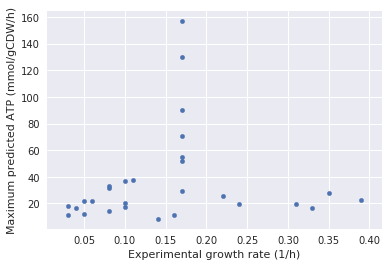

In [5]:
ds.drop(columns=['ATP_min','ATP_mean','ATP_max','std'],inplace=True)
# Plot all data sets
ax = ds.plot.scatter('GR', 'ATP_both')
ax.set_xlabel('Experimental growth rate (1/h)')
ax.set_ylabel('Maximum predicted ATP (mmol/gCDW/h)')

- For the chemostat cellodextrin experiments there is a large amount of available ATP. This excess amounts of ATP are generated due to the cleavage of cellodextirns which may actually be wasted, or the model is not capturing its application.

## Define each type of point and omit cellodextrins

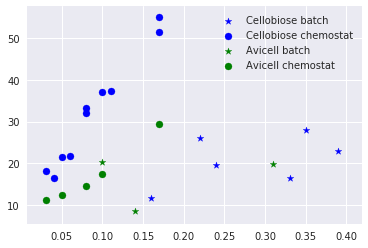

In [6]:
cdf = ds.loc[(ds.Reactor=='Batch') & ds.Medium.str.contains('cellb')]
cb2 = plt.scatter(cdf['GR'], cdf['ATP_both'], c='b', marker='*')

cdf = ds.loc[(ds.Reactor=='Chemostat') & ds.Medium.str.contains('cellb')]
cc = plt.scatter(cdf['GR'], cdf['ATP_both'], c='b', marker='o')

cdf = ds.loc[(ds.Reactor=='Batch') & ds.Medium.str.contains('avcell')]
ab = plt.scatter(cdf['GR'], cdf['ATP_both'], c='g', marker='*')

cdf = ds.loc[(ds.Reactor=='Chemostat') & ds.Medium.str.contains('avcell')]
ac = plt.scatter(cdf['GR'], cdf['ATP_both'], c='g', marker='o')

plt.legend([cb2,cc,ab,ac], ['Cellobiose batch', 'Cellobiose chemostat', 'Avicell batch', 'Avicell chemostat'])

ax.set_xlabel('Experimental growth rate (1/h)')
ax.set_ylabel('Maximum predicted ATP (mmol/gCDW/h)');

## Plot condidtions independently
### Cellobiose conditions



,Strain,Medium,Reactor,GR,ATP_both
index,,,,,
0,WT,MTC-cellb,Batch,0.33,16.472812
1,hydG,MTC-cellb,Batch,0.24,19.433451
2,"hydG, ech",MTC-cellb,Batch,0.22,25.983008
5,WT,AN7-cellb,Batch,0.39,22.917682
6,ppdk,AN7-cellb,Batch,0.35,27.949610


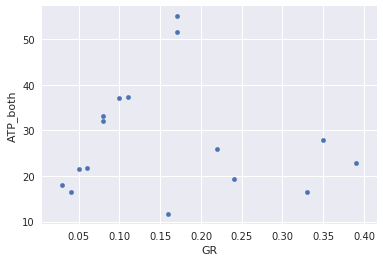

In [7]:
cellb = ds.loc[ds.Medium.str.contains('cellb'), :]
cellb.plot.scatter('GR', 'ATP_both')
cellb.loc[cellb.GR>0.2, :]

- The high growth region corresponds to the batch reactors. This can be due to several reasons:
1) They belong to two different WT strains (ATCC vs DSM)
2) They are two different conditions with different maintenance requirements. Notably  in batch cultures multiple fermentation products are measured, not only acetate and ethanol.


In [8]:
# Train GAM/NGAM using chemostats
cellb_chem_idx = ds.loc[ds.Medium.str.contains('cellb') & ds.Reactor.str.contains('Chemostat'),:].index
excl_idx = list(set(ds.index) - set(cellb_chem_idx))
with model:
    trainout = train(model, exclude_data_index=excl_idx , constraint_mode='both')

print(trainout)

{'GAM': 267.5755257879969, 'NGAM': 8.585593028519803, 'rsquared': 0.973162172711245, 'gamdf':          ATP  growth_rate     medium training_dataset_index
0  18.003814         0.03  MTC-cellb                      9
1  21.561357         0.05  MTC-cellb                     10
2  33.220171         0.08  MTC-cellb                     11
3  37.042713         0.10  MTC-cellb                     12
4  55.051613         0.17  MTC-cellb                     13
5  16.430085         0.04  MTC-cellb                     14
6  21.682628         0.06  MTC-cellb                     15
7  31.995171         0.08  MTC-cellb                     16
8  37.363985         0.11  MTC-cellb                     17
9  51.646613         0.17  MTC-cellb                     18}


There is a good R^2 coefficient, however the values of GAM and NGAM are significantly higher than other models.
(iML uses a GAM of 75.5 and NGAM of 6.8)
The issue with such value is that it will render batch data unusable. In particular, at a substrate uptake rate of ~ -4 cellobiose, the model will predict a maximum growth rate of around 0.1. 

### Cellulose conditions



,Strain,Medium,Reactor,GR,ATP_both
index,,,,,
4,WT-ATCC27405,MTC-avcell,Batch,0.31,19.897273
7,WT,MTC-highavcell-clamped,Batch,0.14,8.407278
8,WT,MTC-highavcell-vented,Batch,0.10,20.266313


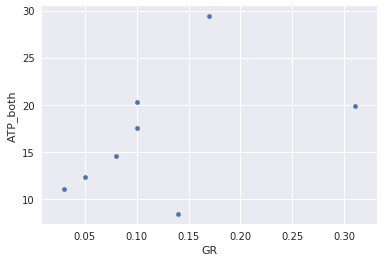

In [9]:
# Print cellobiose points
cellb = ds.loc[ds.Medium.str.contains('avcell'), :]
cellb.plot.scatter('GR', 'ATP_both')
ds.loc[ds.Reactor.str.contains('Batch') & ds.Medium.str.contains('avcell') , :]

In this case the high substrate batch reactor, with a slower growth rate, lies close to the chemostat dataset.

In [10]:
# Train using GAM/NGAM using chemostats
cell_idx = ds.loc[ds.Medium.str.contains('avcell') & (ds.GR <0.2),:].index
excl_idx = list(set(ds.index) - set(cell_idx)) + [7] # 7 is NaN dataset
with model:
    trainout_cellulose = train(model, exclude_data_index=excl_idx , constraint_mode='both')

#trainout_cellulose.pop('gamdf')
print(trainout_cellulose)

{'GAM': 135.00226343777163, 'NGAM': 5.579710144927503, 'rsquared': 0.9564374696376651, 'gamdf':          ATP  growth_rate                 medium training_dataset_index
0  20.266313         0.10  MTC-highavcell-vented                      8
1  11.022894         0.03             MTC-avcell                     23
2  12.294823         0.05             MTC-avcell                     24
3  14.571051         0.08             MTC-avcell                     25
4  17.492980         0.10             MTC-avcell                     26
5  29.381399         0.17             MTC-avcell                     27}


# Batch conditions
It has become aparent that the energetic requirements between chemostat and batch cultures are different. Instead of thinking about cellulose vs cellobiose, a batch energy maintenance can be determined

In [11]:
bds = ds.loc[ds.Reactor=='Batch',:]
bds = bds.drop(8) # The high loading avicell vented datapoint is not consistent with the batch trend
bds = bds.drop(2) # The hydG-ech mutant also seems to be an outlier
batch_outlier_idx = [2,8]
bds


,Strain,Medium,Reactor,GR,ATP_both
index,,,,,
0,WT,MTC-cellb,Batch,0.33,16.472812
1,hydG,MTC-cellb,Batch,0.24,19.433451
3,"hydG, pta-ack",MTC-cellb,Batch,0.16,11.685963
4,WT-ATCC27405,MTC-avcell,Batch,0.31,19.897273
5,WT,AN7-cellb,Batch,0.39,22.917682
6,ppdk,AN7-cellb,Batch,0.35,27.949610
7,WT,MTC-highavcell-clamped,Batch,0.14,8.407278


In [12]:
x = bds['GR'].as_matrix()
y = bds['ATP_both'].as_matrix()
s = stats.linregress(x,y)
print(s)
batch_gam = s[0]
batch_ngam = s[1]
batch_r = s[2]

LinregressResult(slope=58.55453625355648, intercept=2.0484799688321935, rvalue=0.85273504781574, pvalue=0.01474180396983046, stderr=16.040495856586197)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1 FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:2 FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


# Final plot

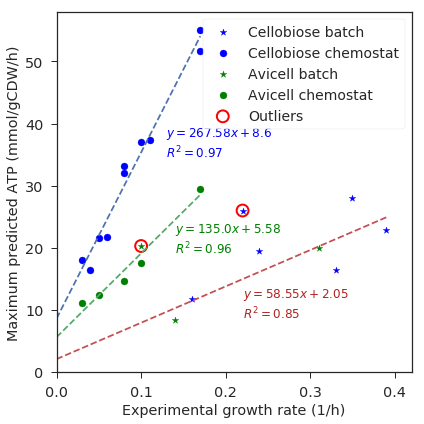

In [13]:
#plt.figure(figsize=(5,5))
#sns.set_style("ticks")
plt.style.use('seaborn-ticks')

## Scatter plot
#plt.rcParams['font.size'] = 12

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

text_fontisze = 12
cdf = ds.loc[(ds.Reactor=='Batch') & ds.Medium.str.contains('cellb')]
cb1 = plt.scatter(cdf['GR'], cdf['ATP_both'], c='b', marker='*')

cdf = ds.loc[(ds.Reactor=='Chemostat') & ds.Medium.str.contains('cellb')]
cc = plt.scatter(cdf['GR'], cdf['ATP_both'], c='b', marker='o')

cdf = ds.loc[(ds.Reactor=='Batch') & ds.Medium.str.contains('avcell')]
ab = plt.scatter(cdf['GR'], cdf['ATP_both'], c='g', marker='*')

cdf = ds.loc[(ds.Reactor=='Chemostat') & ds.Medium.str.contains('avcell')]
ac = plt.scatter(cdf['GR'], cdf['ATP_both'], c='g', marker='o')

# Circle around outliers
cdf = ds.loc[(ds.Reactor=='Batch')]
cdf = cdf.iloc[batch_outlier_idx]
ol = plt.scatter(cdf['GR'], cdf['ATP_both'], s=140, facecolors='none', edgecolors='r',linewidth=2)

# Regression
## Cellobiose
gamdf = trainout['gamdf']
x = gamdf['growth_rate']
y = gamdf['ATP'] 

def line(x_val):
    return trainout['GAM']*x_val+ trainout['NGAM']
plt.plot([0, x[-1:]], [line(0), line(x[-1:])], '--')

equation_str = '$y={}x + {}$\n$R^2={}$'.format(round(trainout['GAM'], 2), round(trainout['NGAM'], 1),
                                               round(trainout['rsquared'], 2))
plt.text(0.13, 35, equation_str, color='b', fontsize=text_fontisze)

## Cellulose
gamdf = trainout_cellulose['gamdf']
x = gamdf['growth_rate']
y = gamdf['ATP']

def line(x_val):
    return trainout_cellulose['GAM']*x_val+ trainout_cellulose['NGAM']
plt.plot([0, x[-1:]], [line(0), line(x[-1:])], '--')

equation_str = '$y={}x + {}$\n$R^2={}$'.format(round(trainout_cellulose['GAM'], 2), round(trainout_cellulose['NGAM'], 2),
                                               round(trainout_cellulose['rsquared'], 2))
plt.text(0.14, 19.5, equation_str, color='g', fontsize=text_fontisze)

## Batch
x = bds['GR']
y = bds['ATP_both']

def line(x_val):
    return batch_gam*x_val+ batch_ngam
plt.plot([0, x[5]], [line(0), line(x[5])], '--')

equation_str = '$y={}x + {}$\n$R^2={}$'.format(round(batch_gam, 2), round(batch_ngam, 2),
                                               round(batch_r, 2))
plt.text(0.22, 9, equation_str, color='firebrick', fontsize=text_fontisze)

## Legend 
  
legend = plt.legend([cb1,cc,ab,ac, ol], ['Cellobiose batch', 'Cellobiose chemostat', 'Avicell batch', 'Avicell chemostat','Outliers'], fontsize=14, frameon=1)
legend.get_frame().set_facecolor('white')



## Labels
ax = plt.gca()
ax.set_xlabel('Experimental growth rate (1/h)')
ax.set_ylabel('Maximum predicted ATP (mmol/gCDW/h)')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('atp_training.svg')


# Model setup
The three different GAM/NGAM configurations will be will be stored in the file atp_parm.csv and read into the model when the method tools.conf_model.set_conditions is used.  

In [14]:
# Create ATP parameter files
with open(os.path.join(settings.MEDIA_ROOT, 'atp_param.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['parameter', 'cellobiose_chemostat','cellulose_chemostat','batch'])
    writer.writerow(['GAM', trainout['GAM'], trainout_cellulose['GAM'], batch_gam])
    writer.writerow(['NGAM', trainout['NGAM'], trainout_cellulose['NGAM'], batch_ngam])

In [15]:
# Create iSG file with batch parameters as default 
model = load_model()

conf_model.set_conditions(model, 'comp_minimal_cellobiose', secretion='common_secretion', reactor_type='batch')
#cb.io.save_json_model(model, os.path.join('iCBI655bigg_cellb_batch.json'))
cb.io.save_json_model(model,os.path.join('intermediate','iCBI665_v7.json'))
